In [16]:
!pip install numpy matplotlib pandas yfinance scikit-learn tensorflow mplfinance

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense
import mplfinance as mpf
import os
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

In [12]:
# Data Config
COMPANY = "TSLA"
TRAIN_START = '2015-01-01'
TRAIN_END = '2020-01-01'
TEST_START = '2020-01-02'
TEST_END = '2020-12-31'
PREDICTION_DAYS = 20
PRICE_VALUE = ["Open", "High", "Low", "Close", "Adj Close","Volume"]
features = PRICE_VALUE

# Model Config
input_shape = (PREDICTION_DAYS, 1)
output_units = 1

# Define layer Config
layer_configs = [
    {'layer_type': 'LSTM', 'num_layers': 2, 'layer_size': 50},
    {'layer_type': 'GRU', 'num_layers': 2, 'layer_size': 50},
    {'layer_type': 'RNN', 'num_layers': 2, 'layer_size': 50},
]

In [13]:
def load_and_process_data(start_date, end_date, data_source="yahoo", company="TSLA",
                          features=["Close"], test_size=0.2, random_split=True,
                          save_data=False, load_data=False, na_method='drop'):
    # Check if loading from local data is requested
    if load_data and os.path.exists("stock_data.csv"):
        data = pd.read_csv("stock_data.csv", index_col=0, parse_dates=True)
    else:
        # Load data from source
        data = yf.download(company, start=start_date, end=end_date, progress=False)

        # Save data if requested
        if save_data:
            data.to_csv("stock_data.csv")

    # Print the columns of the loaded data
    print("Available columns in the data:", data.columns)

    # Keep a copy of the original data for visualization
    original_data = data.copy()

    # Handle NaN values
    if na_method == 'ffill':
        data.fillna(method='ffill', inplace=True)
    elif na_method == 'bfill':
        data.fillna(method='bfill', inplace=True)
    elif na_method == 'drop':
        data.dropna(inplace=True)
    elif na_method == 'zero':
        data.fillna(0, inplace=True)

    # Split original data into train and test sets
    if not random_split:
        split_index = int(len(original_data) * (1 - test_size))
        original_train_data, original_test_data = original_data[:split_index], original_data[split_index:]
    else:
        train_end_idx = int(len(original_data) * (1 - test_size))
        original_train_data = original_data.iloc[:train_end_idx]
        test_start_idx = train_end_idx - len(original_data)
        original_test_data = original_data.iloc[test_start_idx:]

    # Print original data
    print("Original data:\n", original_data[features].head())

    # Scale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data[features] = scaler.fit_transform(data[features])

    # Print scaled data
    print("Scaled data:\n", data[features].head())

    # Split scaled data into train and test sets
    if not random_split:
        split_index = int(len(data) * (1 - test_size))
        train_data, test_data = data[:split_index], data[split_index:]
    else:
        train_end_idx = int(len(data) * (1 - test_size))
        train_data = data.iloc[:train_end_idx]
        test_start_idx = train_end_idx - len(data)
        test_data = data.iloc[test_start_idx:]

    # Return original and scaled data, train/test data, and scaler
    return original_data, original_train_data, original_test_data, train_data, test_data, scaler

original_data, original_train_data, original_test_data, train_data, test_data, scaler = load_and_process_data(
  start_date=TRAIN_START, end_date=TEST_END, company=COMPANY,
  features=features, save_data=True, load_data=False, random_split=False, na_method='ffill'
)

Available columns in the data: Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Original data:
                  Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2015-01-02  14.858000  14.883333  14.217333  14.620667  14.620667  71466000
2015-01-05  14.303333  14.433333  13.810667  14.006000  14.006000  80527500
2015-01-06  14.004000  14.280000  13.614000  14.085333  14.085333  93928500
2015-01-07  14.223333  14.318667  13.985333  14.063333  14.063333  44526000
2015-01-08  14.187333  14.253333  14.000667  14.041333  14.041333  51637500
Scaled data:
                 Open      High       Low     Close  Adj Close    Volume
Date                                                                   
2015-01-02  0.024936  0.020517  0.022560  0.022706   0.022706  0.067348
2015-01-05  0.022361  0.018488  0.020655  0.019938   0.019938  0.077377
2015-01-06  0.020971  0.017797  0.019733

<ipython-input-13-a6f149e092f6>:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


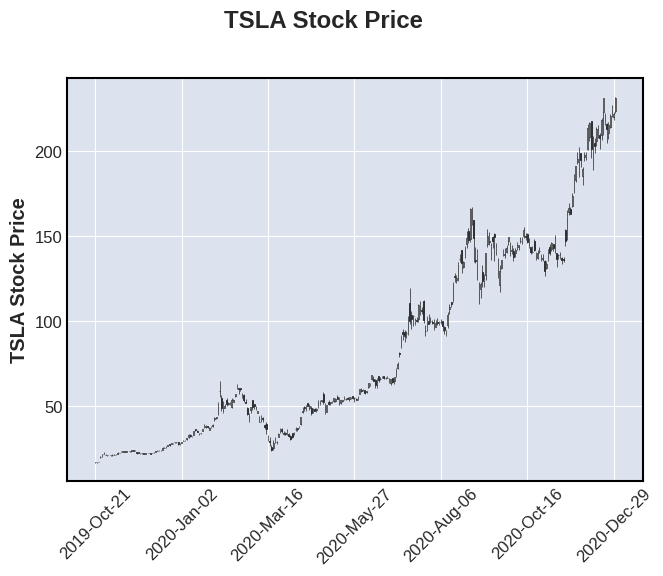

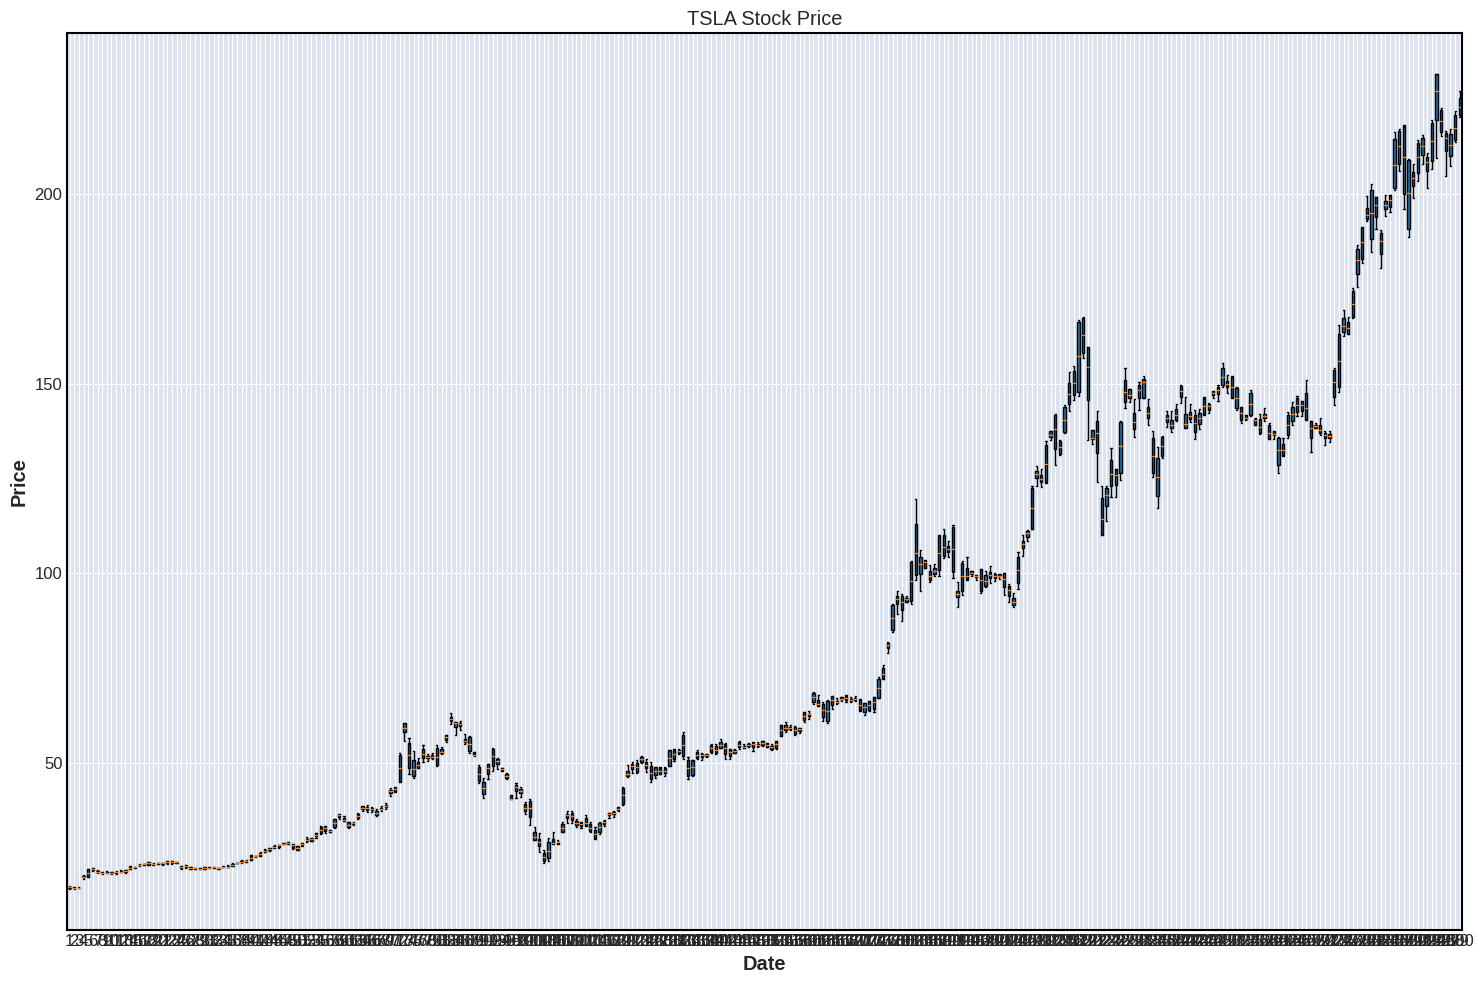

In [14]:
def create_candlestick_chart(dataset):
    mpf.plot(
                dataset,
                type='candle',
                title=f"{COMPANY} Stock Price",
                ylabel=f"{COMPANY} Stock Price"
            )

create_candlestick_chart(original_test_data)


def create_boxplot_from_candlestick_data(dataset, days):
    """
    Create a boxplot from candlestick data for a specified number of days.

    Parameters:
    dataset (pd.DataFrame): The dataset containing the candlestick data.
    days (int): The number of days to include in the boxplot.

    Returns:
    None
    """
    df = pd.DataFrame(dataset)
    # Ensure the number of days does not exceed the length of the dataset
    if days > len(dataset):
        days = len(dataset)

    # Prepare data for boxplot
    boxplot_data = []
    for i in range(days):
        row = dataset.iloc[i]
        day_prices = [row['Open'], row['High'], row['Low'], row['Close']]
        boxplot_data.append(day_prices)

    # Create the boxplot
    plt.figure(figsize=(15, 10))
    plt.boxplot(boxplot_data, patch_artist=True, showfliers=False)
    plt.title(f"{COMPANY} Stock Price")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.tight_layout()
    plt.show()

create_boxplot_from_candlestick_data(original_test_data, 300)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0777 - mae: 0.2051 - val_loss: 0.0084 - val_mae: 0.0737
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0064 - mae: 0.0597 - val_loss: 0.0046 - val_mae: 0.0547
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0044 - mae: 0.0506 - val_loss: 0.0047 - val_mae: 0.0550
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0045 - mae: 0.0501 - val_loss: 0.0042 - val_mae: 0.0525
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0047 - mae: 0.0516 - val_loss: 0.0051 - val_mae: 0.0562
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0040 - mae: 0.0473 - val_loss: 0.0047 - val_mae: 0.0539
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0036 - mae: 0.0458 - val_loss: 0.0037 - val_mae: 0.0488
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0035 - mae: 0.0443 - val_loss: 0.0039 - val_mae: 0.0491
Epoch 9/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0034 - mae: 0.

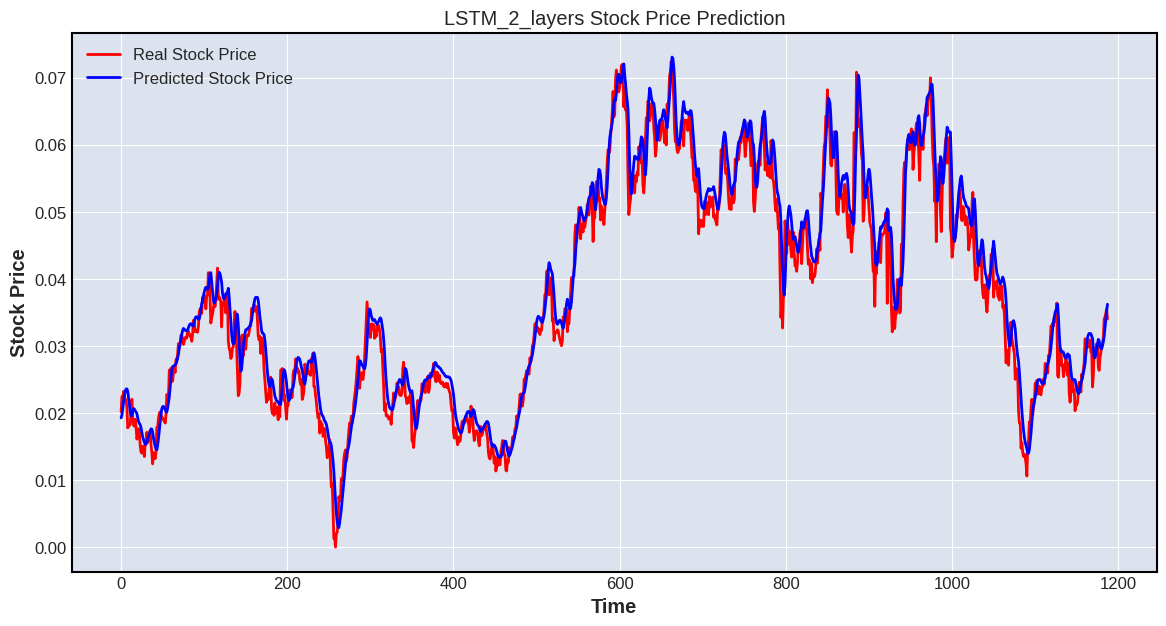

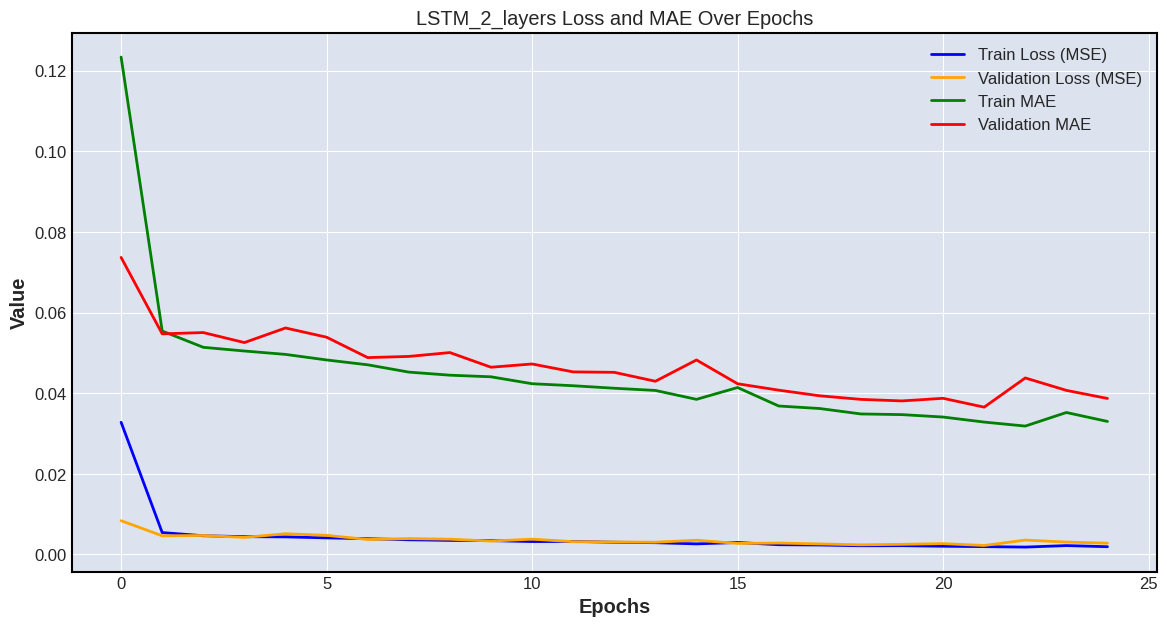

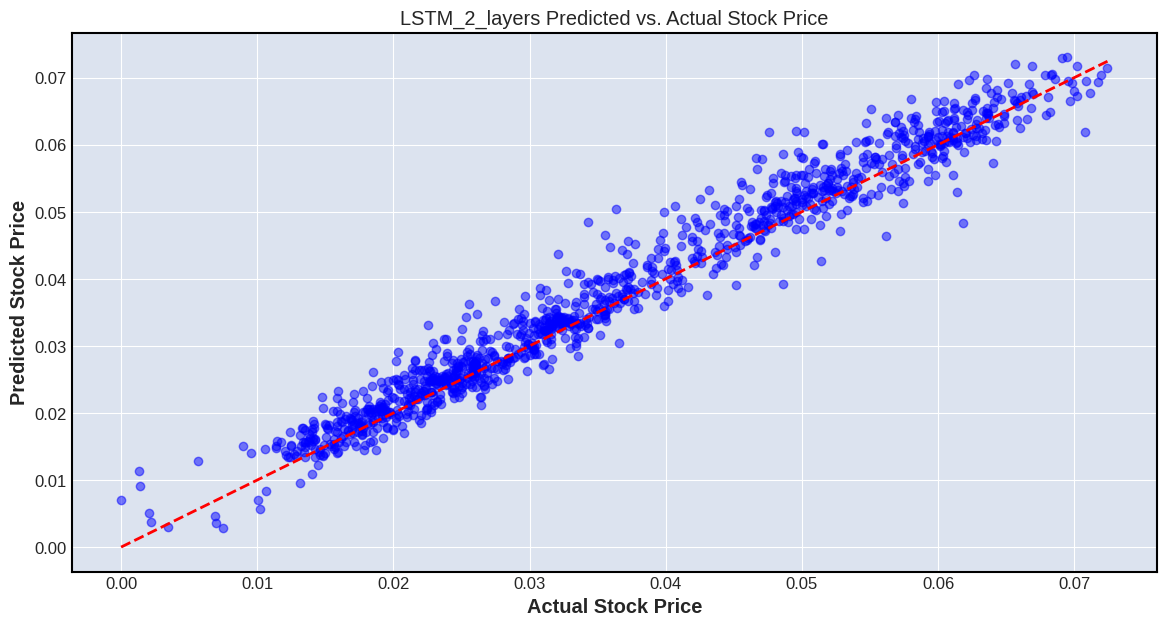

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0908 - mae: 0.2271 - val_loss: 0.0053 - val_mae: 0.0553
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0048 - mae: 0.0558 - val_loss: 0.0026 - val_mae: 0.0397
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0022 - mae: 0.0351 - val_loss: 0.0022 - val_mae: 0.0357
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0018 - mae: 0.0322 - val_loss: 0.0020 - val_mae: 0.0347
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0016 - mae: 0.0304 - val_loss: 0.0019 - val_mae: 0.0339
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0015 - mae: 0.0296 - val_loss: 0.0019 - val_mae: 0.0327
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0016 - mae: 0.0302 - val_loss: 0.0020 - val_mae: 0.0324
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0015 - mae: 0.0275 - val_loss: 0.0017 - val_mae: 0.0313
Epoch 9/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0017 - mae: 0.

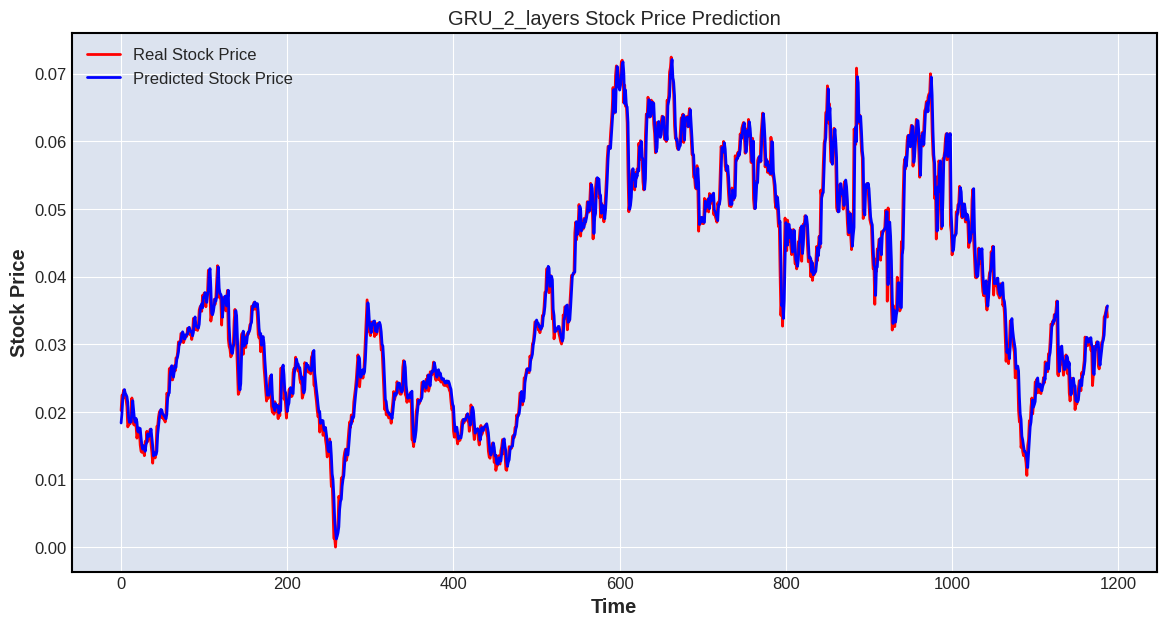

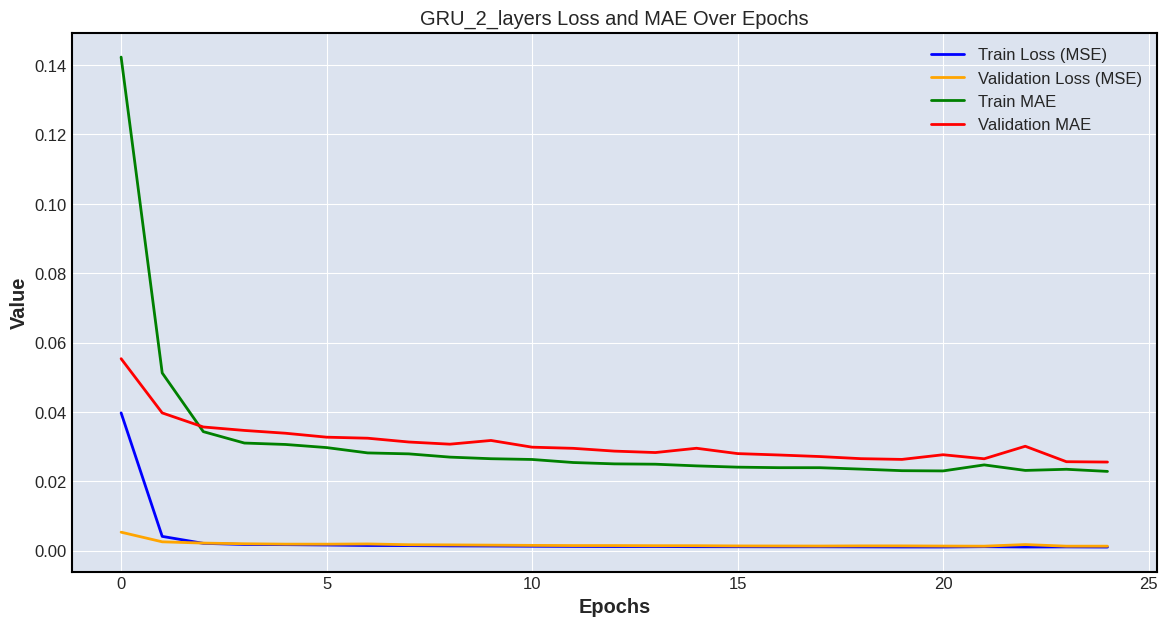

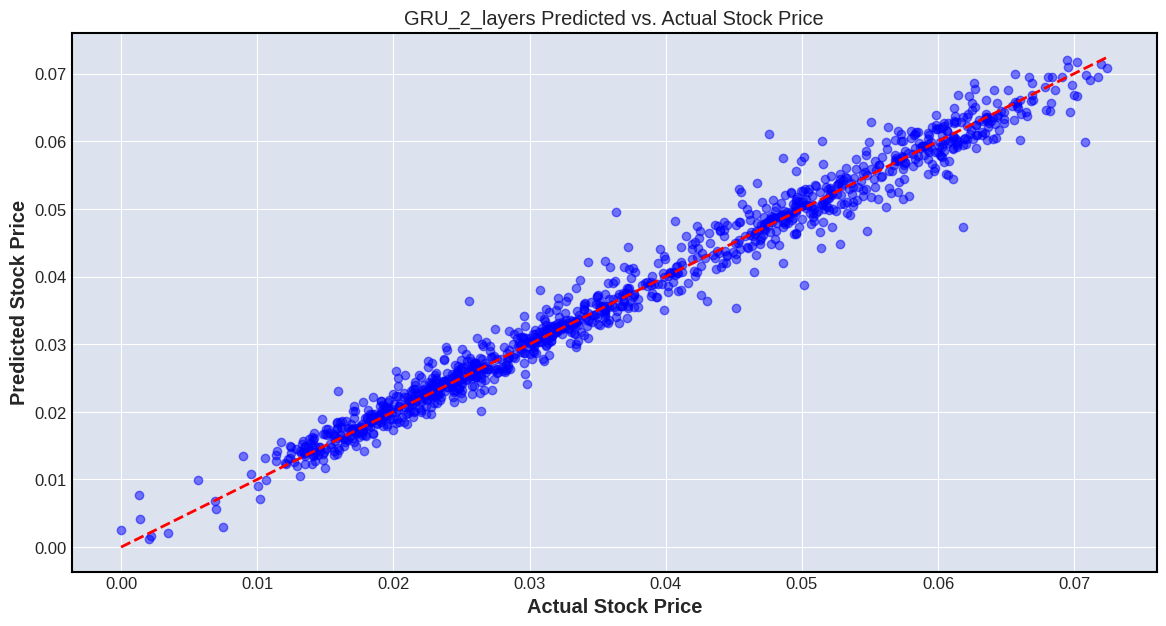

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.1427 - mae: 0.2613 - val_loss: 0.0138 - val_mae: 0.0938
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0104 - mae: 0.0774 - val_loss: 0.0063 - val_mae: 0.0637
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0052 - mae: 0.0540 - val_loss: 0.0042 - val_mae: 0.0519
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0038 - mae: 0.0463 - val_loss: 0.0041 - val_mae: 0.0508
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0031 - mae: 0.0416 - val_loss: 0.0034 - val_mae: 0.0449
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0029 - mae: 0.0393 - val_loss: 0.0025 - val_mae: 0.0395
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0023 - mae: 0.0355 - val_loss: 0.0027 - val_mae: 0.0388
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0020 - mae: 0.0327 - val_loss: 0.0023 - val_mae: 0.0369
Epoch 9/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0018 - mae: 0.

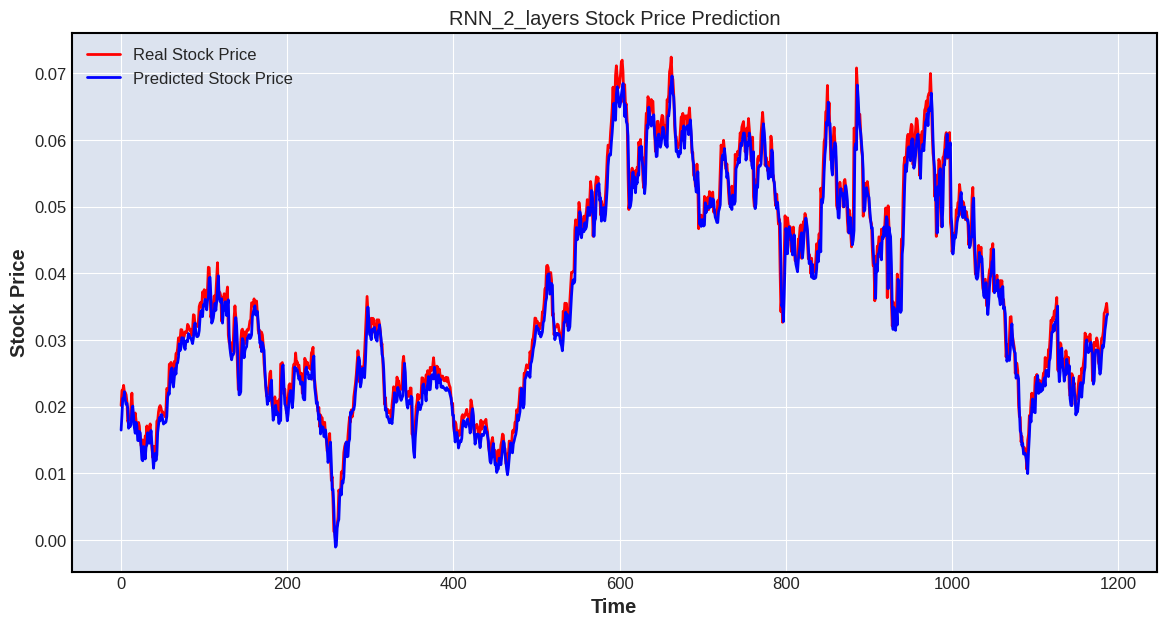

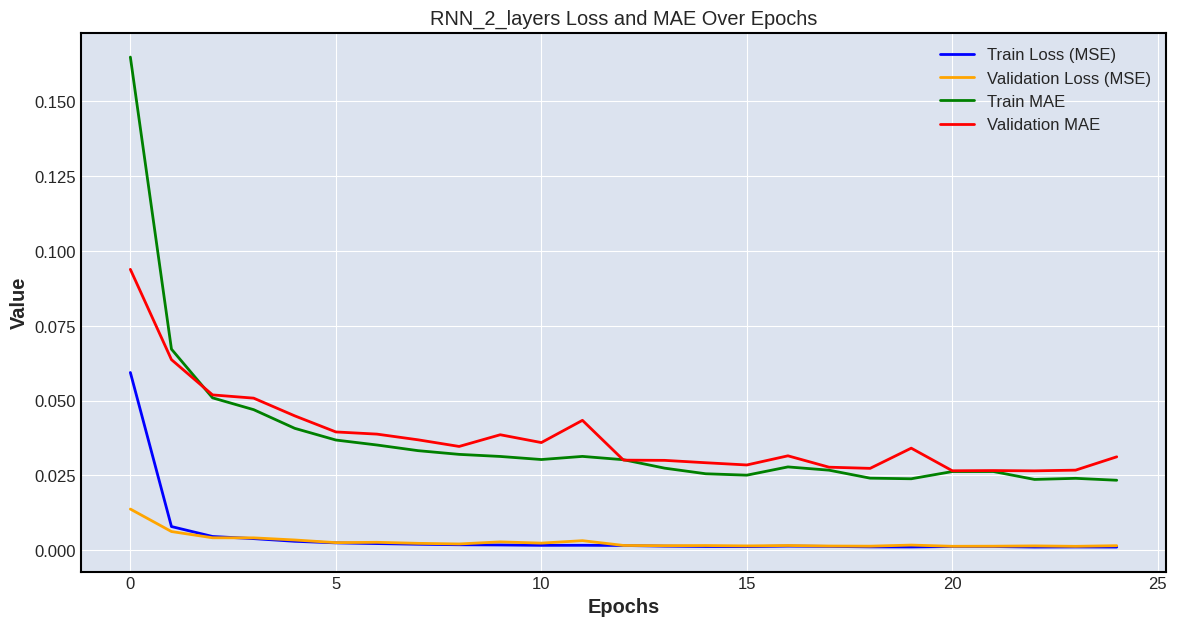

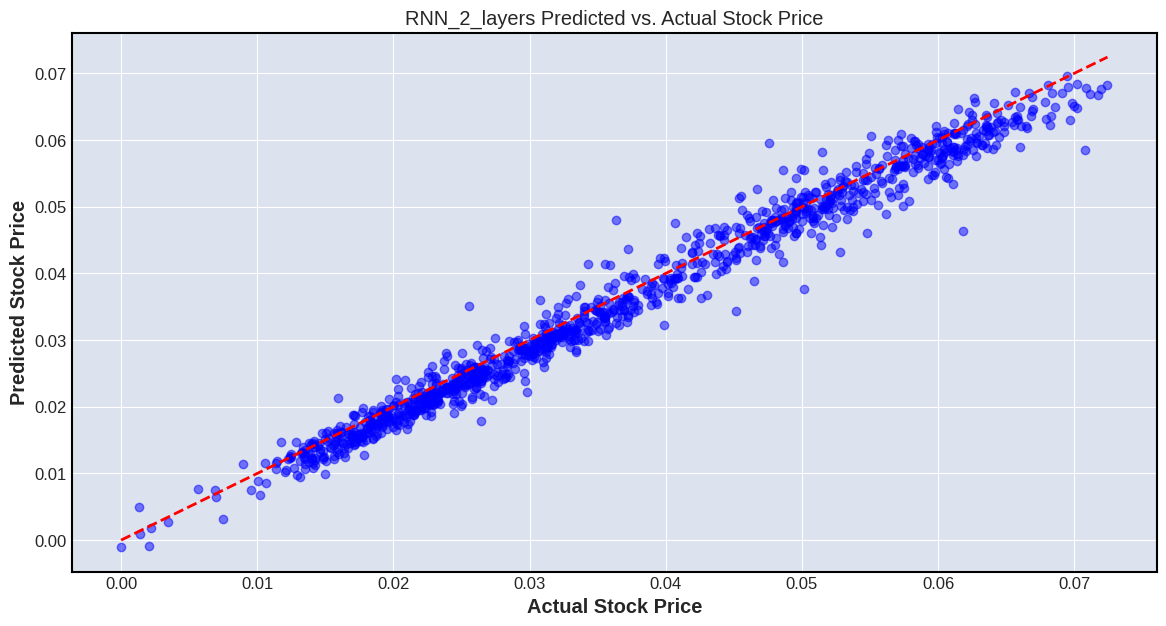

In [15]:
scaled_data = scaler.fit_transform(train_data['Close'].values.reshape(-1, 1))

# Prepare training data
x_train, y_train = [], []
for x in range(PREDICTION_DAYS, len(scaled_data)):
    x_train.append(scaled_data[x-PREDICTION_DAYS:x])
    y_train.append(scaled_data[x])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Prepare testing data
x_test, y_test = [], []
for x in range(PREDICTION_DAYS, len(scaled_data)):
    x_test.append(scaled_data[x-PREDICTION_DAYS:x])
    y_test.append(scaled_data[x])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

def create_dl_model(num_layers, layer_size, layer_type, input_shape, output_units):
    """
    Creates a deep learning model based on the specified parameters.

    Parameters:
        num_layers (int): Number of layers in the model.
        layer_size (int): Number of units in each layer.
        layer_type (str): Type of the layer ('LSTM', 'GRU', 'RNN').
        input_shape (tuple): Shape of the input data (timesteps, features).
        output_units (int): Number of output units in the final dense layer.

    Returns:
        model: A compiled Keras model.
    """
    model = Sequential()

    for i in range(num_layers):
        if layer_type == 'LSTM':
            model.add(LSTM(layer_size, return_sequences=(i < num_layers - 1), input_shape=input_shape if i == 0 else None))
        elif layer_type == 'GRU':
            model.add(GRU(layer_size, return_sequences=(i < num_layers - 1), input_shape=input_shape if i == 0 else None))
        elif layer_type == 'RNN':
            model.add(SimpleRNN(layer_size, return_sequences=(i < num_layers - 1), input_shape=input_shape if i == 0 else None))
        else:
            raise ValueError("Invalid layer type. Choose from 'LSTM', 'GRU', 'RNN'.")

    model.add(Dense(output_units))  # Linear activation for regression
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])  # Use mean squared error for regression

    return model



def train_and_plot_model(model, X_train, y_train, X_test, y_test, scaler, epochs=25, batch_size=32, model_name="model"):
    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

    # Predicting the test set results
    predicted_stock_price = model.predict(X_test)
    predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
    real_stock_price = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Plotting the stock price results
    plt.figure(figsize=(14, 7))
    plt.plot(real_stock_price, color='red', label='Real Stock Price')
    plt.plot(predicted_stock_price, color='blue', label='Predicted Stock Price')
    plt.title(f'{model_name} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    # Plotting the loss and MAE
    plt.figure(figsize=(14, 7))
    plt.plot(history.history['loss'], color='blue', label='Train Loss (MSE)')
    plt.plot(history.history['val_loss'], color='orange', label='Validation Loss (MSE)')
    plt.plot(history.history['mae'], color='green', label='Train MAE')
    plt.plot(history.history['val_mae'], color='red', label='Validation MAE')
    plt.title(f'{model_name} Loss and MAE Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    # Plotting Predicted vs. Actual Values
    plt.figure(figsize=(14, 7))
    plt.scatter(real_stock_price, predicted_stock_price, color='blue', alpha=0.5)
    plt.plot([real_stock_price.min(), real_stock_price.max()], [real_stock_price.min(), real_stock_price.max()], color='red', linestyle='--')
    plt.title(f'{model_name} Predicted vs. Actual Stock Price')
    plt.xlabel('Actual Stock Price')
    plt.ylabel('Predicted Stock Price')
    plt.show()

# Train and plot for each model
for config in layer_configs:
    model = create_dl_model(config['num_layers'], config['layer_size'], config['layer_type'], input_shape, output_units)
    model_name = f"{config['layer_type']}_{config['num_layers']}_layers"
    train_and_plot_model(model, x_train, y_train, x_test, y_test, scaler, epochs=25, batch_size=32, model_name=model_name)